# 3. 정책 반복 (Policy Iteration)

이번 챕터에서는 동적 계획법(Dynamic Programming)의 두 번째 주요 알고리즘인 **정책 반복(Policy Iteration)**을 학습한다. 앞서 배운 가치 반복(Value Iteration)이 가치 함수를 최적화하여 정책을 얻는 방식이었다면, 정책 반복은 **현재 정책을 평가(Evaluation)하고 개선(Improvement)하는 과정을 반복**하여 최적 정책에 도달하는 방식이다.

### 0. 라이브러리 및 환경 설정

이전 챕터와 동일하게 `gymnasium`을 사용하여 미로(Maze) 환경을 구성한다. 정책 반복 역시 환경의 모델(전이 확률 )이 필요하므로, 이를 포함한 환경 클래스를 정의한다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [2]:
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Discrete(25) # 5x5 그리드
        self.action_space = spaces.Discrete(4) # 상, 우, 하, 좌
        self.state = 0
        self.target = 24 # 목표 지점 (4, 4)
        self.row_len = 5
        self.render_mode = 'rgb_array'

        # 전이 모델 P[state][action] = [(prob, next_state, reward, done)] 계산
        self.P = {}
        for s in range(25):
            self.P[s] = {}
            for a in range(4):
                self.P[s][a] = []
                row, col = divmod(s, self.row_len)

                # 행동에 따른 좌표 이동
                moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
                dr, dc = moves[a]
                next_row, next_col = row + dr, col + dc

                # 맵 경계 처리
                next_row = np.clip(next_row, 0, 4)
                next_col = np.clip(next_col, 0, 4)
                next_state = next_row * self.row_len + next_col

                # 보상 및 종료 조건 설정
                done = (next_state == self.target)
                reward = -1.0
                if s == self.target: # 목표 상태에서는 이동 불가
                     next_state = self.target
                     reward = 0.0
                     done = True

                self.P[s][a].append((1.0, next_state, reward, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = 0
        return self.state, {}

    def step(self, action):
        prob, next_state, reward, done = self.P[self.state][action][0]
        self.state = next_state
        return self.state, reward, done, False, {}

    def render(self):
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        curr_r, curr_c = divmod(self.state, 5)
        target_r, target_c = divmod(self.target, 5)
        grid[curr_r, curr_c] = [0, 0, 255] # 에이전트 (파란색)
        grid[target_r, target_c] = [0, 255, 0] # 목표 (녹색)
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

env = Maze()
print("Maze 환경이 준비되었다.")

Maze 환경이 준비되었다.


---

## 1. 정책 반복 (Policy Iteration) 이론

정책 반복은 크게 두 단계의 루프로 구성된다.

1. **정책 평가 (Policy Evaluation):** 현재 고정된 정책 를 따라갔을 때의 상태 가치함수 $V_\pi(s)$를 구한다.
2. **정책 발전 (Policy Improvement):** 구해진 가치함수 $V_\pi(s)$를 바탕으로 더 나은 행동을 선택하도록 정책 를 업데이트한다 (탐욕적 업데이트).

이 과정을 정책이 더 이상 변하지 않을 때(수렴할 때)까지 반복하면 최적 정책 $\pi^*$와 최적 가치함수 $V^*$를 얻게 된다.

---

## 2. 정책 평가 (Policy Evaluation) 구현

첫 번째 단계인 정책 평가는 벨만 기대 방정식(Bellman Expectation Equation)을 반복적으로 계산하여 수행한다. 현재 정책 가 고정되어 있으므로, 각 상태에서 정책이 선택한 행동에 대한 기대 보상만을 고려한다.

In [3]:
def policy_evaluation(env, policy, gamma=0.99, theta=1e-6):
    """
    주어진 정책(policy)에 대한 가치 함수(V)를 계산한다.
    """
    # 모든 상태의 가치를 0으로 초기화
    V = np.zeros(env.observation_space.n)

    while True:
        delta = 0
        # 모든 상태에 대해 반복
        for s in range(env.observation_space.n):
            # 현재 정책이 선택하는 행동 가져오기
            action = policy[s]

            # 모델 P에서 전이 정보 가져오기 (결정론적 환경이므로 항목은 1개)
            prob, next_state, reward, done = env.P[s][action][0]

            # 벨만 기대 방정식 적용
            # 목표 상태(done)인 경우 다음 상태 가치는 0으로 간주하거나 reward만 남음
            new_v = prob * (reward + gamma * V[next_state] * (1 - done))

            # 변화량 갱신
            delta = max(delta, np.abs(new_v - V[s]))
            V[s] = new_v

        # 가치 함수의 변화가 임계값보다 작으면 수렴한 것으로 판단
        if delta < theta:
            break

    return V

print("정책 평가 함수 정의 완료")

정책 평가 함수 정의 완료


---

## 3. 정책 발전 (Policy Improvement) 구현

두 번째 단계인 정책 발전은 평가된 가치 함수 $V(s)$를 이용하여, 각 상태에서 가장 높은 기대 가치를 주는 행동(탐욕적 행동, Greedy Action)을 선택하도록 정책을 갱신한다.

In [4]:
def policy_improvement(env, V, gamma=0.99):
    """
    주어진 가치 함수(V)를 바탕으로 더 나은 정책(policy)을 생성한다.
    """
    policy = np.zeros(env.observation_space.n, dtype=int)

    for s in range(env.observation_space.n):
        q_values = []

        # 가능한 모든 행동에 대해 Q-value(행동 가치) 계산
        for a in range(env.action_space.n):
            prob, next_state, reward, done = env.P[s][a][0]
            q_val = prob * (reward + gamma * V[next_state] * (1 - done))
            q_values.append(q_val)

        # 가장 높은 Q-value를 가진 행동을 선택 (Argmax)
        policy[s] = np.argmax(q_values)

    return policy

print("정책 발전 함수 정의 완료")

정책 발전 함수 정의 완료


---

## 4. 정책 반복 (Policy Iteration) 전체 루프

이제 위에서 정의한 두 함수를 결합하여 전체 알고리즘을 완성한다.

1. 초기 정책을 랜덤으로 생성한다.
2. 정책 평가 -> 정책 발전을 반복한다.
3. 정책이 더 이상 바뀌지 않으면(Stable) 종료한다.

In [5]:
def policy_iteration(env, gamma=0.99):
    # 1. 임의의 정책 초기화 (모두 0번 행동 등으로 초기화하거나 랜덤)
    policy = np.random.choice(env.action_space.n, size=env.observation_space.n)

    step = 0
    while True:
        # 2. 정책 평가: 현재 정책에 대한 가치 함수 계산
        V = policy_evaluation(env, policy, gamma)

        # 3. 정책 발전: 가치 함수를 기반으로 새로운 정책 생성
        new_policy = policy_improvement(env, V, gamma)

        # 4. 정책 안정성 확인 (정책이 변했는지 확인)
        if np.array_equal(new_policy, policy):
            print(f"정책 반복이 {step}회 만에 수렴했다.")
            break

        policy = new_policy
        step += 1

    return policy, V

# 알고리즘 실행
optimal_policy, optimal_values = policy_iteration(env)

print("\n[최적 정책 (0:Up, 1:Right, 2:Down, 3:Left)]")
print(optimal_policy.reshape(5, 5))

print("\n[최적 가치 함수]")
print(optimal_values.reshape(5, 5))

정책 반복이 7회 만에 수렴했다.

[최적 정책 (0:Up, 1:Right, 2:Down, 3:Left)]
[[1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 1 0]]

[최적 가치 함수]
[[-7.72553056 -6.79346521 -5.85198506 -4.90099501 -3.940399  ]
 [-6.79346521 -5.85198506 -4.90099501 -3.940399   -2.9701    ]
 [-5.85198506 -4.90099501 -3.940399   -2.9701     -1.99      ]
 [-4.90099501 -3.940399   -2.9701     -1.99       -1.        ]
 [-3.940399   -2.9701     -1.99       -1.          0.        ]]


---

## 5. 결과 시각화 및 시뮬레이션

구해진 최적 정책을 시각적으로 확인하고, 에이전트가 실제로 목표를 잘 찾아가는지 시뮬레이션한다.

### 5.1 가치 및 정책 시각화

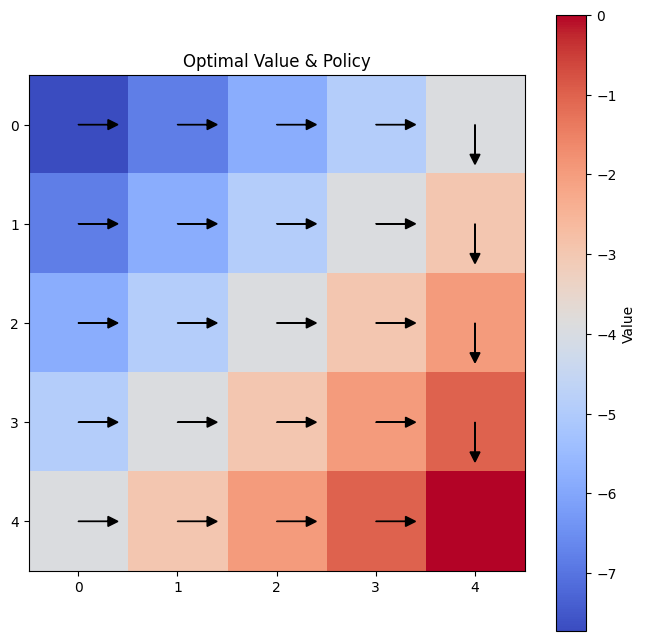

In [6]:
def plot_policy(values, policy):
    plt.figure(figsize=(8, 8))
    # 가치 함수 히트맵
    plt.imshow(values.reshape(5, 5), cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Value')
    plt.title('Optimal Value & Policy')

    # 정책 화살표
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)} # dx, dy
    for s in range(25):
        if s == 24: continue # 목표 위치
        r, c = divmod(s, 5)
        action = policy[s]
        dx, dy = arrows[action]
        plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='black', ec='black')

    plt.show()

plot_policy(optimal_values, optimal_policy)

### 5.2 에이전트 주행 시뮬레이션

시뮬레이션 종료


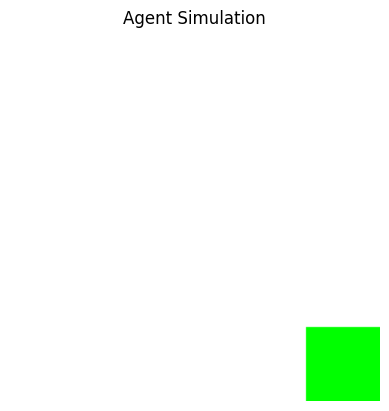

In [7]:
from IPython import display

def run_simulation(env, policy):
    state, _ = env.reset()
    done = False
    step = 0

    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("Agent Simulation")

    while not done and step < 20:
        action = policy[state]
        state, reward, done, _, _ = env.step(action)

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        step += 1

    print("시뮬레이션 종료")

run_simulation(env, optimal_policy)

### 마무리

정책 반복(Policy Iteration)은 가치 반복(Value Iteration)에 비해 한 번의 루프(평가+발전) 내에서 더 많은 계산(평가 단계의 반복)을 수행한다. 하지만 일반적으로 **더 적은 횟수의 외부 루프**만으로 최적 정책에 수렴하는 특성이 있다. 이 튜토리얼을 통해 에이전트가 환경 모델을 알고 있을 때, 계획(Planning)을 통해 최적의 경로를 찾아내는 과정을 확인할 수 있다.